In [1]:
from utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
vol_file = '../Analysis/depreciated/analysis_sections_gain.csv'
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_xls_file = dat_xls_file.reset_index()
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_label = np.arange(-t_pre, t_post)/300
t_sig = 240

## Get example cell
* fish 1
* cell 6

In [2]:
nfish = 1
row = dat_xls_file.iloc[nfish]
folder = row['folder']
fish = row['fish']
_ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
r_swim = _['r_swim']
l_swim = _['l_swim']
visu = _['visu']
task_period = _['task_period']
swim_task_index = _['swim_task_index']

trial_valid = np.ones(len(swim_starts)).astype('bool')
for n, n_swim in enumerate(swim_starts[:-1]):        
    # examine the swim with short inter-swim-interval
    if swim_starts[n+1] - n_swim < t_sig:    
        trial_valid[n] = False

p_swim = l_swim+r_swim

ncell_ = 6
_ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
# trial_valid = _['trial_valid']
sub_swim = _['sub_swim'][ncell_]
spk_swim = _['spk_swim'][ncell_]*300
spk_list = _['raw_spk_swim'][ncell_]

sub_list = sub_swim-sub_swim[:, 70:75].mean(axis=-1, keepdims=True)

trial_valid_fit = trial_valid & ((visu[:,:t_pre-10]<=0).sum(axis=-1)==0)

## Get x, y data for fit
* y : neural dynamics at time t
* x : spike history, swim history, visual history

In [15]:
Y_dat = []
X_dat = []
spike_pad = 2
swim_pad = 30
visu_pad = 60
for n_, dff_ in enumerate(sub_list):
    if not trial_valid_fit[n_]:
        continue
    spk_ = spk_list[n_]
    swim_ = p_swim[n_]
    visu_ = -visu[n_]
    visu_[visu_<0]=0
    for n_time in range(t_pre, t_pre+240):
        spk_history=spk_[n_time-spike_pad:n_time]
        swim_history=swim_[n_time-swim_pad:n_time+swim_pad]
        if n_time>120:
            visu_history=visu_[n_time-visu_pad:n_time]
        else:
            visu_history=np.zeros(visu_pad)
        Y_dat.append(dff_[n_time]-dff_[n_time-30])
        X_dat.append(np.r_[-spk_history, -np.sqrt(swim_history)/100, np.sqrt(visu_history)/100])

Y_dat = np.array(Y_dat)
X_dat = np.array(X_dat)

## Fit

In [16]:
w, rnorm = nnls(X_dat, Y_dat)

## Explained variance

In [18]:
Y_hat = X_dat.dot(w)
ev_model = 1 - ((Y_dat-Y_hat)**2).sum()/((Y_dat-Y_dat.mean())**2).sum()
print(f'EV for model {ev_model}')
ev_spike = 1 - ((Y_dat-X_dat[:,:spike_pad].dot(w[:2]))**2).sum()/((Y_dat-Y_dat.mean())**2).sum()
print(f'EV for spike {ev_spike}')
ev_swim = 1 - ((Y_dat-X_dat[:,spike_pad:(spike_pad+swim_pad*2)].dot(w[2:62]))**2).sum()/((Y_dat-Y_dat.mean())**2).sum()
print(f'EV for swim {ev_swim}')
ev_visual = 1 - ((Y_dat-X_dat[:,(spike_pad+swim_pad*2):].dot(w[62:]))**2).sum()/((Y_dat-Y_dat.mean())**2).sum()
print(f'EV for visual {ev_visual}')

EV for model 0.17507564954069643
EV for spike -0.0010646979445037008
EV for swim 0.1341296682863835
EV for visual 0.019693404910390844


## Kernel

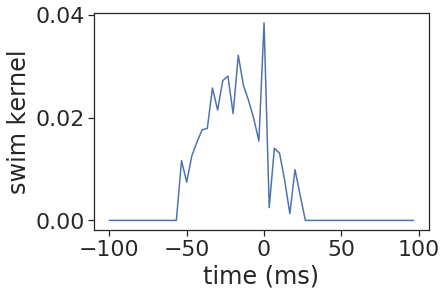

In [19]:
plt.plot(np.arange(-swim_pad,swim_pad)/300*1000, w[spike_pad:(spike_pad+swim_pad*2)])
plt.ylabel('swim kernel')
plt.xlabel('time (ms)')
plt.show()

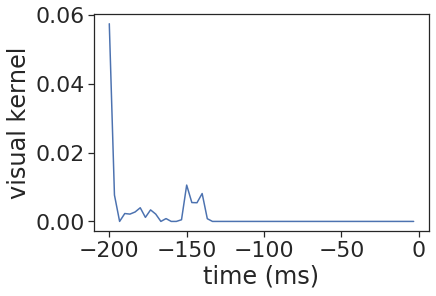

In [20]:
plt.plot(np.arange(-visu_pad,0)/300*1000, w[(spike_pad+swim_pad*2):])
plt.ylabel('visual kernel')
plt.xlabel('time (ms)')
plt.show()